In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from xgboost import XGBClassifier

# Reading data and reprocessing

In [2]:
df=pd.read_csv('../input/magic-gamma-telescope-dataset/telescope_data.csv')

In [3]:
df=df.drop(['Unnamed: 0'],axis='columns')

In [4]:
df.head(5)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [5]:
df.shape


(19020, 11)

In [6]:
df.describe().T.sort_values(ascending =0,by='mean').style.background_gradient(cmap='BuGn').bar(subset=['std'], color='red').bar(subset=['mean'], color='blue')

,count,mean,std,min,25%,50%,75%,max
fDist,19020.000000,193.818026,74.731787,1.282600,142.492250,191.851450,240.563825,495.561000
fLength,19020.000000,53.250154,42.364855,4.283500,24.336000,37.147700,70.122175,334.177000
fAlpha,19020.000000,27.645707,26.103621,0.000000,5.547925,17.679500,45.883550,90.000000
fWidth,19020.000000,22.180966,18.346056,0.000000,11.863800,17.139900,24.739475,256.382000
fM3Long,19020.000000,10.545545,51.000118,-331.780000,-12.842775,15.314100,35.837800,238.321000
fSize,19020.000000,2.825017,0.472599,1.941300,2.477100,2.739600,3.101600,5.323300
fConc,19020.000000,0.380327,0.182813,0.013100,0.235800,0.354150,0.503700,0.893000
fM3Trans,19020.000000,0.249726,20.827439,-205.894700,-10.849375,0.666200,10.946425,179.851000
fConc1,19020.000000,0.214657,0.110511,0.000300,0.128475,0.196500,0.285225,0.675200
fAsym,19020.000000,-4.331745,59.206062,-457.916100,-20.586550,4.013050,24.063700,575.240700


In [7]:
features=df.columns
for feature in features:
     print(f'{feature}--->{df[feature].unique()}')

fLength--->[ 28.7967  31.6036 162.052  ...  75.4455 120.5135 187.1814]
fWidth--->[ 16.0021  11.7235 136.031  ...  47.5305  76.9018  53.0014]
fSize--->[2.6449 2.5185 4.0612 ... 3.6872 2.8307 3.2093]
fConc--->[0.3918 0.5303 0.0374 ... 0.7544 0.5857 0.0944]
fConc1--->[0.1982 0.3773 0.0187 ... 0.3591 0.3791 0.3934]
fAsym--->[  27.7004   26.2722  116.741  ...   -9.3561    5.8043 -167.3125]
fM3Long--->[  22.011    23.8238  -64.858  ...   41.0562  -93.5224 -168.4558]
fM3Trans--->[ -8.2027  -9.9574 -45.216  ...  -9.4662 -63.8389  31.4755]
fAlpha--->[40.092   6.3609 76.96   ... 30.2987 84.6874 52.731 ]
fDist--->[ 81.8828 205.261  256.788  ... 256.5166 408.3166 272.3174]
class--->['g' 'h']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [9]:
df.isnull().sum()

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

In [10]:
df.duplicated().sum()

115

In [11]:
df.drop_duplicates (inplace=True) 

<AxesSubplot:>

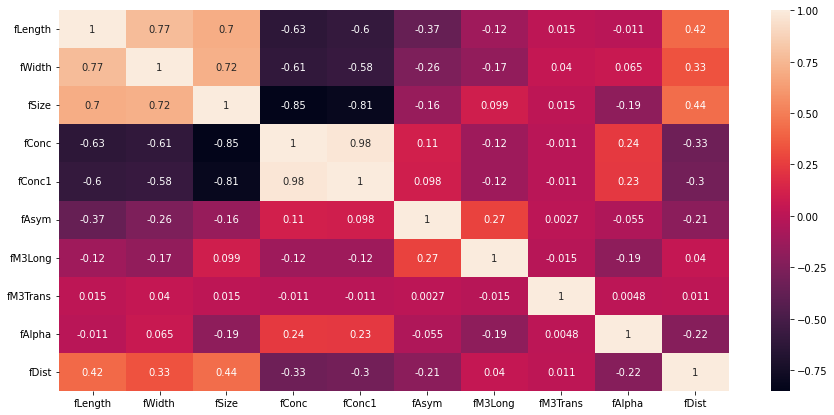

In [12]:
correl=df.corr()
fig = plt.figure(figsize=(15,7))
sns.heatmap(correl,annot=True)

In [13]:
df.columns


Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fAlpha', 'fDist', 'class'],
      dtype='object')

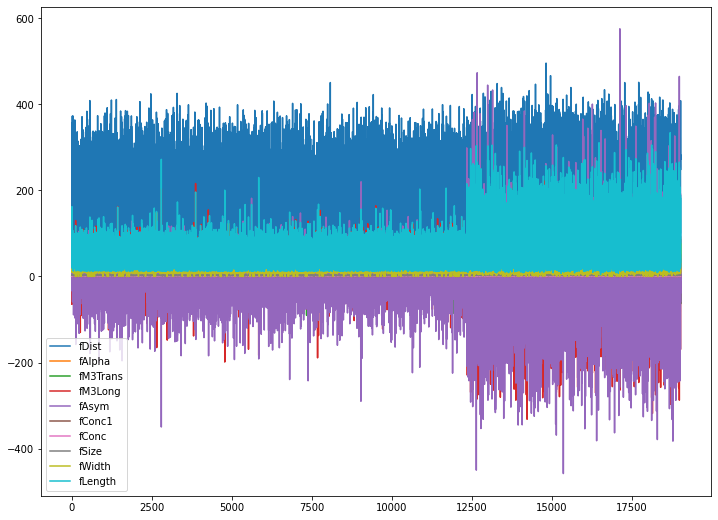

In [14]:
plt.figure(figsize = (12,9))
features =['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fAlpha', 'fDist']
features.reverse()# reverses the sorting order of the elements.
for feature in features:
    plt.plot(df[feature],label = feature)
plt.legend()
plt.show()

In [15]:
df.replace({"class":{'g':0,'h':1}},inplace=True)

In [16]:
df.head(5)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0


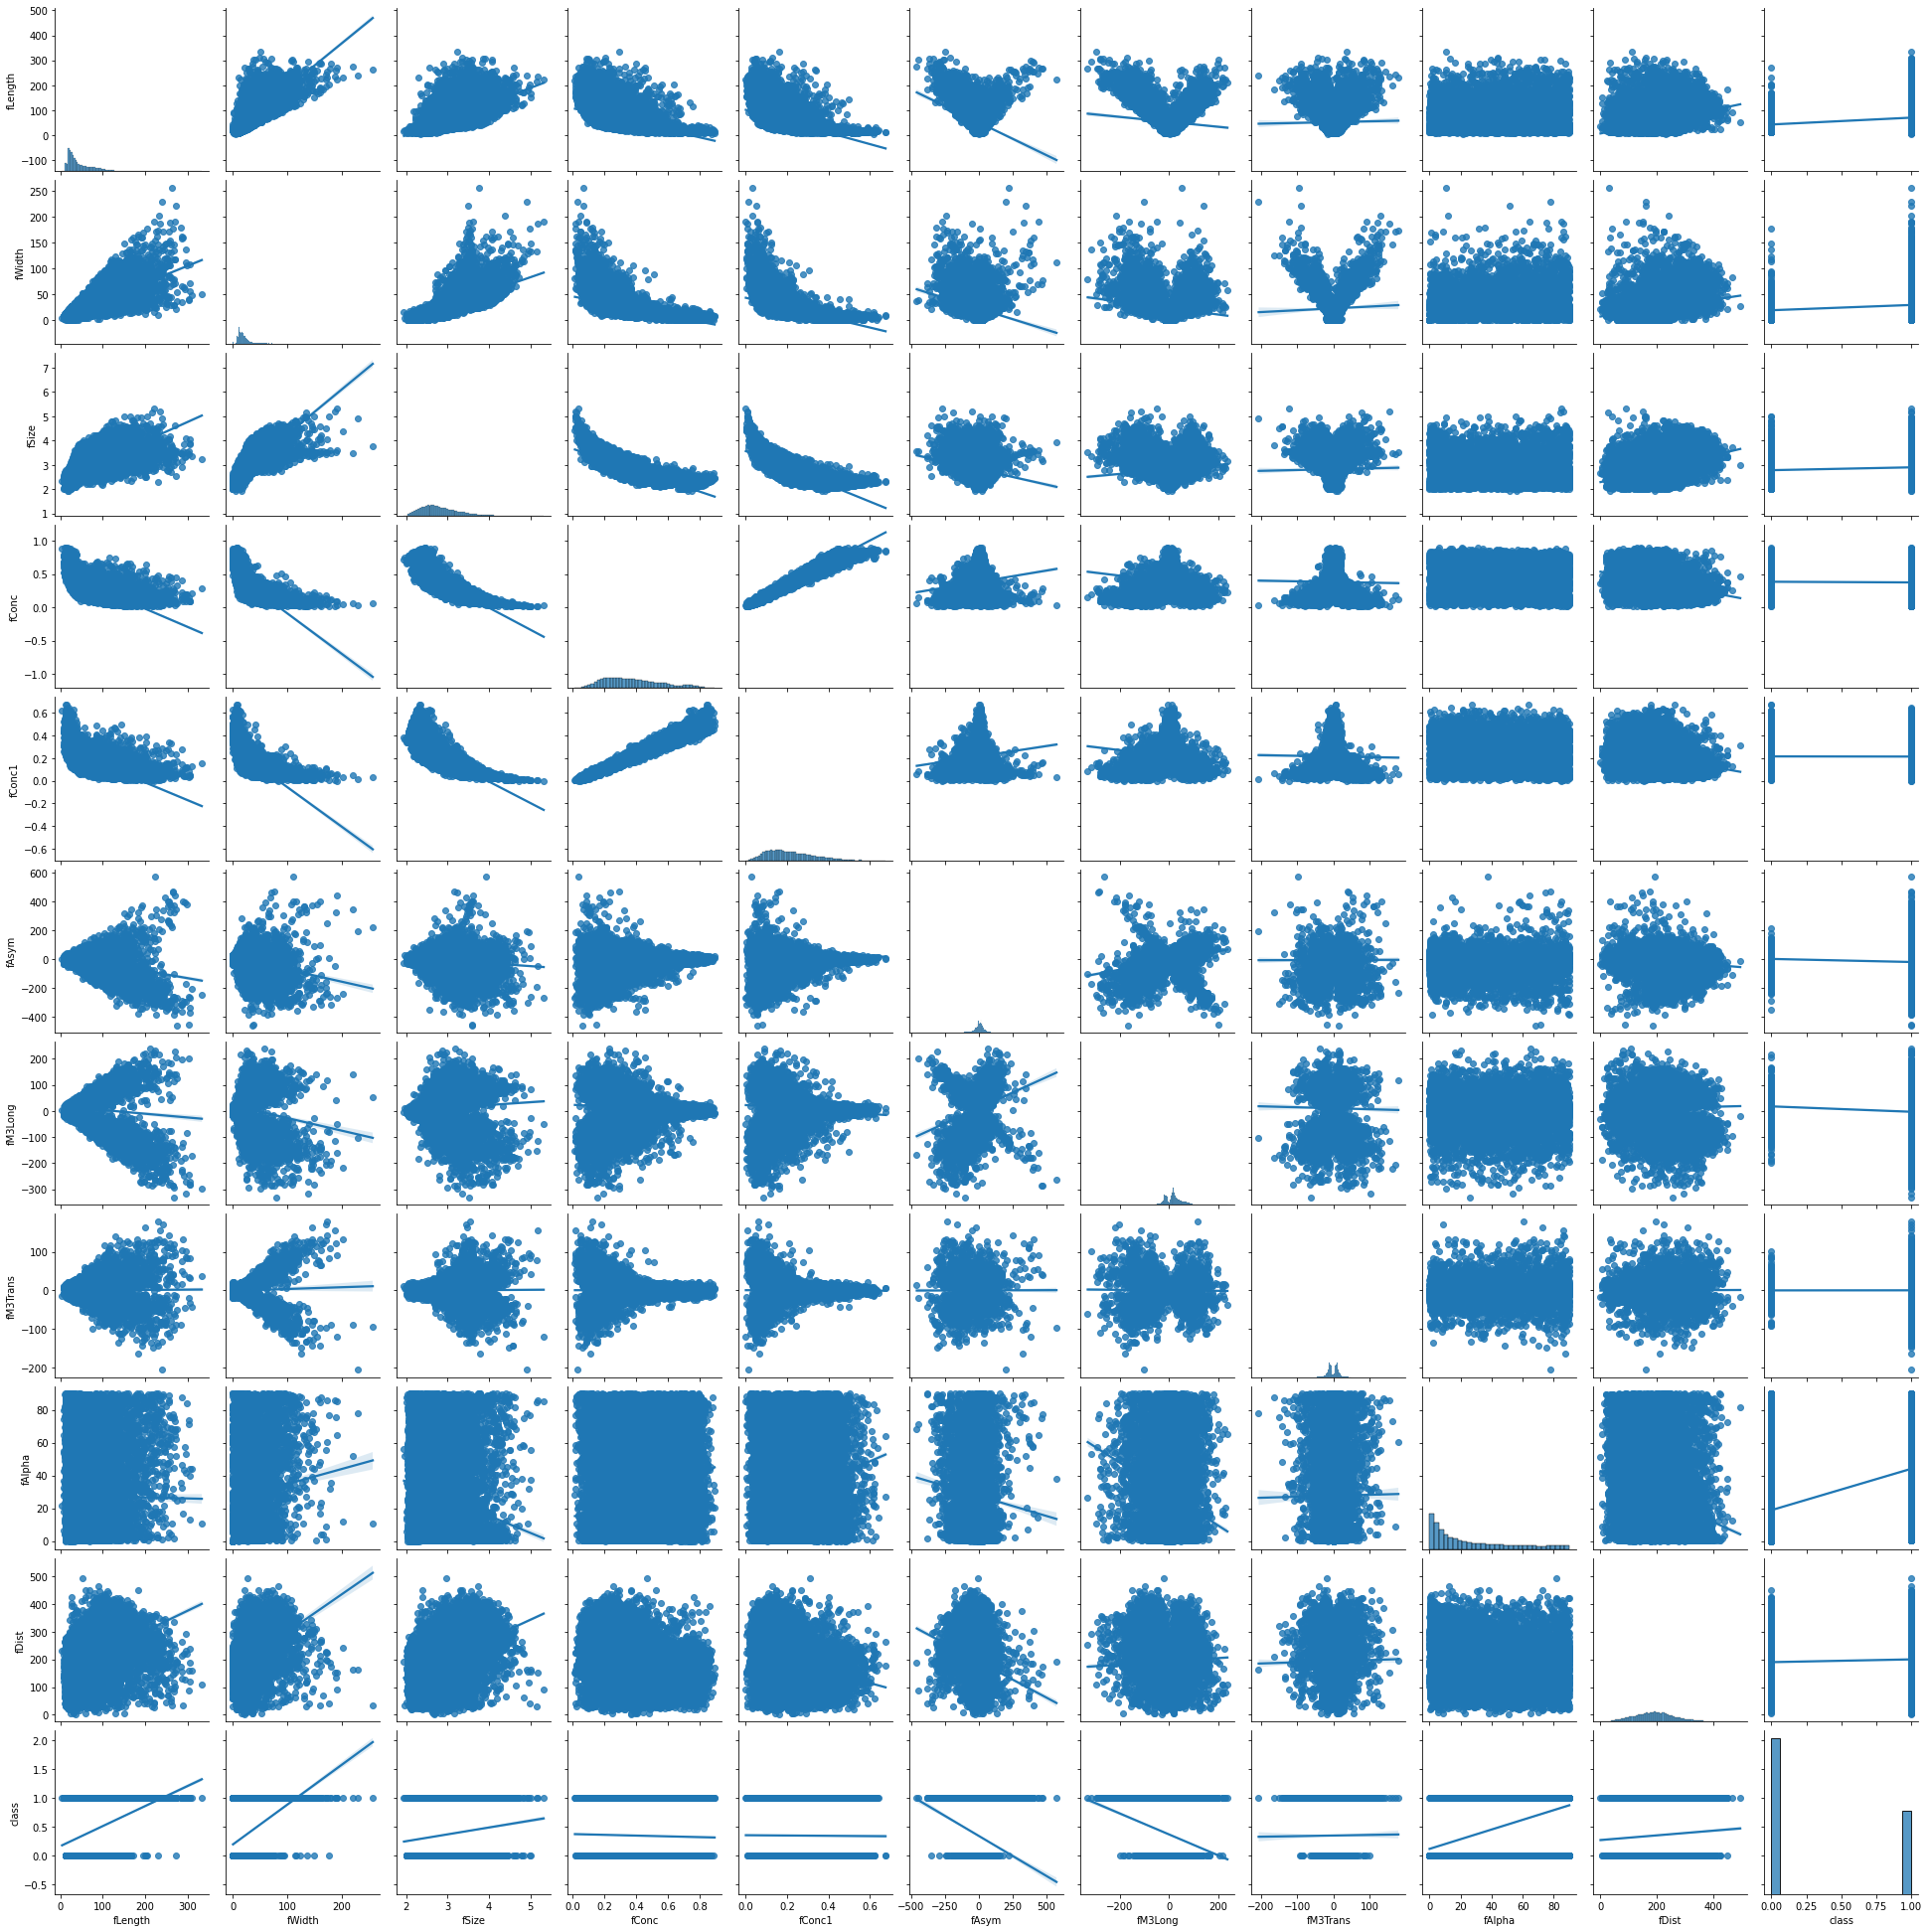

In [17]:
sns.pairplot(df, kind='reg')

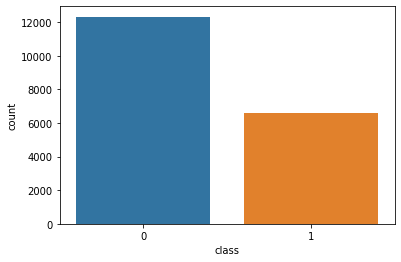

In [18]:
#count left
sns.countplot(x='class',data=df)
plt.show()

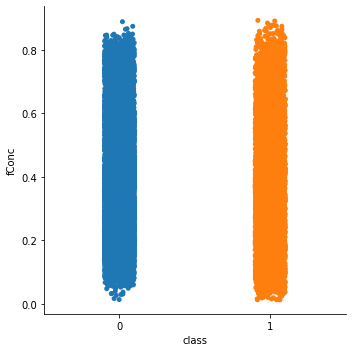

In [19]:
sns.catplot(x='class',y='fConc',data=df)
plt.show()

# Model

In [20]:
df['class'].value_counts()

0    12332
1     6573
Name: class, dtype: int64

In [21]:
X=df.drop(['class'],axis='columns')
y=df['class']

In [22]:


smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

0    12332
1    12332
Name: class, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm,test_size=0.2,random_state=5)

In [24]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [25]:
len(X_train)

19731

In [26]:
X_train[:10]

array([[-0.10916322,  1.39057817, -0.21233143, -0.49872608, -0.79384367,
         0.35366553,  0.74270658, -1.42359646, -0.93535511,  0.34220937],
       [ 0.730259  ,  0.42134802,  1.74290245, -0.80289487, -0.78383531,
        -1.08579039, -1.25010079, -0.91280982, -1.12758542,  2.22938099],
       [-0.37942025, -0.29952845, -0.6081554 ,  1.04796947,  1.08772835,
         0.58813209,  0.2198897 , -0.64237798,  0.62024224, -0.05802328],
       [-0.74087413, -0.52887539, -0.79220501,  0.79660394,  0.83115035,
         0.48549036,  0.15059873, -0.34412133,  0.39676964, -1.04011494],
       [ 0.58125391,  0.24990806,  0.31977028, -0.69948848, -0.63825913,
         0.0953385 ,  0.55150021, -0.55971487, -0.88048457,  1.75925558],
       [-0.81645876, -0.21967849, -0.83357885,  0.53313766,  0.41261886,
         0.01231757, -0.4498086 ,  0.46394216,  2.06943761,  0.12290002],
       [-0.8624814 , -0.43432945, -0.70433891,  1.63265559,  1.91933223,
         0.07892281, -0.374624  , -0.58230812

In [27]:
X_train.shape

(19731, 10)

In [28]:
from sklearn.naive_bayes import GaussianNB


model_params = {
             
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
   
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
        }   
    },
       'XGB_Classifier':{
        'model':XGBClassifier(),
        'params':{
            'base_score':[0.5]
            
        }
    } 
        
     
}


In [29]:
from sklearn.model_selection import GridSearchCV
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X,y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,model,best_score,best_params
0,random_forest,0.864004,{'n_estimators': 10}
1,logistic_regression,0.790690,{'C': 5}
2,naive_bayes_gaussian,0.731870,{}
3,decision_tree,0.817614,{'criterion': 'gini'}
4,XGB_Classifier,0.878974,{'base_score': 0.5}


In [30]:
reg=RandomForestClassifier(max_features=5, n_estimators=50)
reg.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=50)

In [31]:
reg.score( X_test, y_test)

0.8767484289479018

In [32]:
y_predicted = reg.predict(X_test)

In [33]:
y_predicted [:5]

array([0, 0, 0, 0, 1])

In [34]:
y_test[:5]

1326     0
2204     0
5698     0
15899    1
12381    1
Name: class, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2477
           1       0.89      0.86      0.87      2456

    accuracy                           0.88      4933
   macro avg       0.88      0.88      0.88      4933
weighted avg       0.88      0.88      0.88      4933



In [36]:
y_predicted = reg.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
cm

array([[2207,  270],
       [ 338, 2118]])

Text(69.0, 0.5, 'Truth')

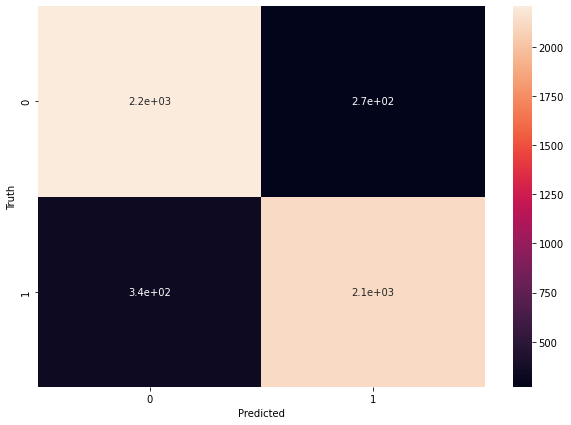

In [37]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_predicted)
print(f'{mean_squared_error}: {mse}')

<function mean_squared_error at 0x7fcdefe0f050>: 0.12325157105209811


# Hyperparameter Tuning

In [39]:
max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,100,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print("The best parameters  %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Dataframe of Grid search parameters and their Accuracy scores

In [ ]:
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

# Contour plot

In [ ]:
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()
grid_contour

#  Reshapeing the data by pivoting the data into an m by n matrix 



In [ ]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot('max_features', 'n_estimators')
grid_pivot

In [ ]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [ ]:

import plotly.graph_objects as go


layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features') 
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

# 3D Plot


In [ ]:


import plotly.graph_objects as go


fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

